<a href="https://colab.research.google.com/github/yckamra/COMP-432-Project/blob/main/COMP432_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os # For file manipulation
import torch # Machine learning library
import matplotlib.pyplot as plt # For graphing
import numpy as np # For math library and matrices
from sklearn.metrics import classification_report
from google.colab import drive # For accessing Google Drive
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import random

To enable Colab's local cuda GPU do the following:
Go to Runtime > Change runtime type > Set Hardware accelerator to GPU > Save.

In [ ]:
print(torch.cuda.is_available()) # See if cuda GPU is accessible

True


Mount your Google Drive account to Google Colab to access Dataset 1 image directories. We will also allow for grabbing Dataset 1 from your desktop.

In [ ]:
drive.mount('/content/drive') # Mounting Google Drive
# Copy dataset from Google Drive to Colab's local storage (if not too large)
!cp -r /content/drive/MyDrive/COMP432Project/Datasets/ /content/dataset/

drive_path = '/content/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Find the ResNet documentation here: https://pytorch.org/hub/pytorch_vision_resnet/

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None) # Load in ResNet18 model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# Setting the seeds to ensure the same results
seed = 42
torch.manual_seed(seed)        # PyTorch seed for CPU
torch.cuda.manual_seed(seed)   # PyTorch seed for current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs (if using multiple)
np.random.seed(seed)           # NumPy seed

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

In [ ]:
def create_image_path_array(image_directory):
  # Empty list for all our processed images
  image_paths = []

  # Traverse the directory and subdirectories to find all .tif files
  for root, dirs, files in os.walk(image_directory):
      for filename in files:
          if filename.endswith(".tif"):
              # Get full image path
              image_path = os.path.join(root, filename)
              image_paths.append(image_path)


  return image_paths

In [ ]:
  # Get the paths of all images to allow for splitting into train and test and random shuffling
  MUS_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Datasets/MUS')
  NORM_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Datasets/NORM')
  STR_paths = create_image_path_array('/content/drive/MyDrive/COMP432Project/Datasets/STR')
  print(drive_path + 'STR')
  # Create output labels for our images
  MUS_labels = [0] * len(MUS_paths)
  NORM_labels = [1] * len(NORM_paths)
  STR_labels = [2] * len(STR_paths)

  # Combine all paths and labels into one list
  all_paths = MUS_paths + NORM_paths + STR_paths
  all_labels = MUS_labels + NORM_labels + STR_labels

  # Shuffle our training data
  all_paths, all_labels = shuffle(all_paths, all_labels, random_state=seed)

  # Split our dataset into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(all_paths, all_labels, test_size=0.2, random_state=seed)

  # Split our train dataset into train and cross-validate sets
  X_train, X_cross, y_train, y_cross = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

/content/dataset/STR


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load the image
        image = Image.open(self.image_paths[index]).convert('RGB')

        # Apply our 'preprocess' transformations (i.e. resizing, normalization)
        if self.transform:
            image = self.transform(image)

        # Get the respective label
        label = self.labels[index]

        return image, label

# Preprocessing transformations for ResNet input
preprocess = transforms.Compose([
  transforms.Resize(256),               # Resize to 256 pixels on shorter side
  transforms.CenterCrop(224),           # Crop center to 224x224
  transforms.ToTensor(),                # Convert to PyTorch tensor
  transforms.Normalize(                 # Normalize using ImageNet mean and std
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  ),
])
# Create dataset
train_dataset = ImageDataset(X_train, y_train, transform=preprocess)
cross_dataset = ImageDataset(X_cross, y_cross, transform=preprocess)
test_dataset = ImageDataset(X_test, y_test, transform=preprocess)

In [ ]:
# Setting hyperparameters
num_epochs = 10
learning_rate = 0.0001
batch_size = 128
momentum=0.4 # This is for SGD if decided to be the best optimizer (our evaluation shows it is not)
weight_decay=1e-4

# Model optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2) # Patience of 3 may be a little too aggressive

# Loss function creation
criterion = nn.CrossEntropyLoss()

# Set epoch number to zero
epoch_num = 0

# DataLoader for test data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
cross_loader = DataLoader(cross_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

# Lists for train and CV accuracies and losses
train_accuracies = []
train_losses = []
cross_accuracies = []
cross_losses = []

In [ ]:
def calculate_accuracy(model, dataloader, device):
  # Initializing the loss to zero
  the_loss = 0.0

  # Set model to evaluation mode
  model.eval()

  # Disable gradient computation for testing/inference
  with torch.no_grad():
    total = 0  # Total number of samples
    correct = 0  # Number of correct predictions
    test_loss = 0.0  # Accumulated test loss

  for images, labels in dataloader:
    # Move images and labels to the device (CPU or GPU)
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass to get predictions
    outputs = model(images)

    # Calculate loss
    loss = criterion(outputs, labels)
    the_loss += loss.item()

    # Get predicted labels (we really don't want raw logits so we are using argmax)
    _, predicted = torch.max(outputs, 1)

    # Count total and correct predictions
    total += labels.size(0)  # Total number of test samples
    correct += (predicted == labels).sum().item()  # Correct predictions

  # Calculate accuracy
  accuracy = 100 * correct / total
  return accuracy, the_loss

In [ ]:
# Put the model into the GPU
if torch.cuda.is_available():
  model.to('cuda')

# Training loop
for epoch in range(num_epochs):

    # Set the model to training mode
    model.train()

    for batch_images, batch_labels in train_loader:
        # Move data to GPU
        if torch.cuda.is_available():
            batch_images = batch_images.to('cuda')
            batch_labels = batch_labels.to('cuda')

        # Zero the gradients as this is a new batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_images)

        # Calculate loss
        loss = criterion(outputs, batch_labels)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients (limits how big gradients can be)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step with our optimizer
        optimizer.step()

    epoch_num += 1

    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get our accuracies and losses, then store inside our lists
    train_accuracy, train_loss = calculate_accuracy(model, train_loader, device)
    cross_accuracy, cross_loss = calculate_accuracy(model, cross_loader, device)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    cross_accuracies.append(cross_accuracy)
    cross_losses.append(cross_loss)

    # Step the scheduler using the cross-validation loss
    scheduler.step(cross_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]:")

    # Print train loss and accuracy
    print(f'Train Loss: {train_loss / len(train_loader):.4f}')
    print(f'Train Accuracy: {train_accuracy:.2f}%')

    # Print test loss and accuracy
    print(f'Cross-Validation Loss: {cross_loss / len(cross_loader):.4f}')
    print(f'Cross-Validation Accuracy: {cross_accuracy:.2f}%\n')

Epoch [1/10]:
Train Loss: 1.8452
Train Accuracy: 64.87%
Cross-Validation Loss: 1.9641
Cross-Validation Accuracy: 61.25%

Epoch [2/10]:
Train Loss: 0.7043
Train Accuracy: 79.24%
Cross-Validation Loss: 0.8945
Cross-Validation Accuracy: 75.73%

Epoch [3/10]:
Train Loss: 0.2596
Train Accuracy: 90.99%
Cross-Validation Loss: 0.3108
Cross-Validation Accuracy: 88.85%

Epoch [4/10]:
Train Loss: 0.2170
Train Accuracy: 91.30%
Cross-Validation Loss: 0.2902
Cross-Validation Accuracy: 88.33%

Epoch [5/10]:
Train Loss: 0.3641
Train Accuracy: 85.36%
Cross-Validation Loss: 0.5550
Cross-Validation Accuracy: 79.69%

Epoch [6/10]:
Train Loss: 0.4706
Train Accuracy: 86.54%
Cross-Validation Loss: 0.4954
Cross-Validation Accuracy: 86.56%

Epoch [7/10]:
Train Loss: 0.1723
Train Accuracy: 93.23%
Cross-Validation Loss: 0.2909
Cross-Validation Accuracy: 89.69%

Epoch [8/10]:
Train Loss: 0.0354
Train Accuracy: 99.27%
Cross-Validation Loss: 0.0909
Cross-Validation Accuracy: 96.56%

Epoch [9/10]:
Train Loss: 0.0285

In [ ]:
def graph_metric(train_list, cross_list, epoch_num, loss_or_accuracy_string):

    plt.plot(range(1, epoch_num + 1), train_list, marker='o', linestyle='-', color='b', label='train')
    plt.plot(range(1, epoch_num + 1), cross_list, marker='o', linestyle='-', color='r', label='cross-validation')
    plt.title(f'Model {loss_or_accuracy_string} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(loss_or_accuracy_string)
    plt.grid(True)
    plt.legend()
    plt.show()

# Gets predictions of loader data on our model
def collect_predictions_and_targets(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # No need for gradients during evaluation
        for batch_features, batch_targets in loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                batch_features = batch_features.to('cuda')
                batch_targets = batch_targets.to('cuda')

            # Forward pass to get predictions
            outputs = model(batch_features)

            # Get predicted class (argmax)
            _, preds = torch.max(outputs, dim=1)

            # Store predictions and targets
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy
            all_targets.extend(batch_targets.cpu().numpy())

    return all_preds, all_targets

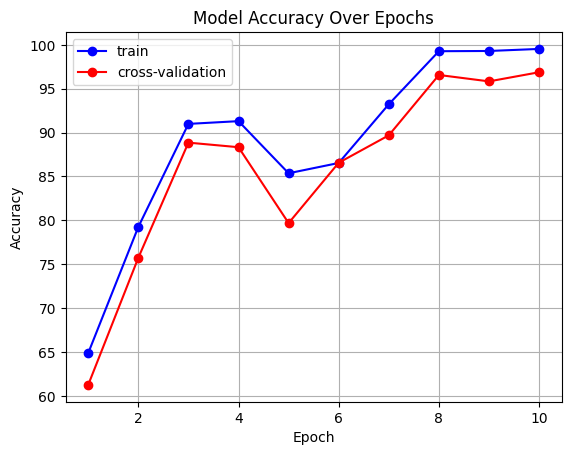

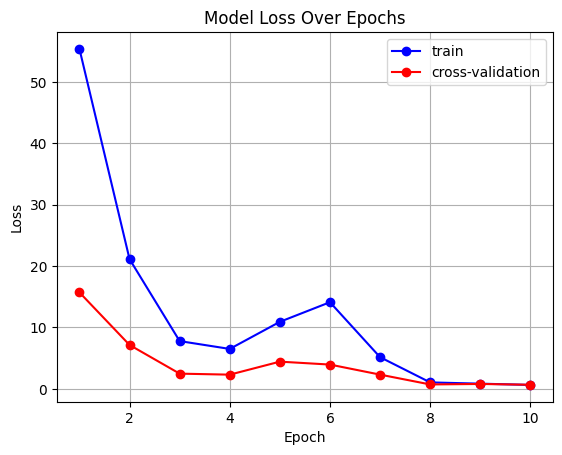

Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1263
           1       1.00      1.00      1.00      1261
           2       0.99      0.99      0.99      1316

    accuracy                           1.00      3840
   macro avg       1.00      1.00      1.00      3840
weighted avg       1.00      1.00      1.00      3840

Cross-Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       320
           1       1.00      0.98      0.99       349
           2       0.92      0.98      0.95       291

    accuracy                           0.97       960
   macro avg       0.97      0.97      0.97       960
weighted avg       0.97      0.97      0.97       960



In [ ]:
graph_metric(train_accuracies, cross_accuracies, epoch_num, 'Accuracy')
graph_metric(train_losses, cross_losses, epoch_num, 'Loss')

# Collect train predictions and labels
train_preds, train_targets = collect_predictions_and_targets(train_loader, model)

# Collect test predictions and labels
cross_preds, cross_targets = collect_predictions_and_targets(cross_loader, model)

# Generate classification report
train_report = classification_report(train_targets, train_preds)
cross_report = classification_report(cross_targets, cross_preds)

# Print the report
print("Train Set Classification Report:")
print(train_report)
print("Cross-Validation Set Classification Report:")
print(cross_report)

Once done training and diagnosing the model run the cell below to test our model against our test set: Only use once absolutely sure the model is of good quality.

In [ ]:
# Collect test predictions and labels
test_preds, test_targets = collect_predictions_and_targets(test_loader, model)

# Generate classification report
test_report = classification_report(test_targets, test_preds)

# Print the report
print("Test Set Classification Report:")
print(test_report)

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       417
           1       0.99      0.99      0.99       390
           2       0.95      0.97      0.96       393

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



In [ ]:
# Double check to see if the drive is mounted
drive.mount('/content/drive') # Mounting Google Drive

# Define the path to save the model in Colab's local storage
model_save_path = '/content/resnet18_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

# Copy the saved model to Google Drive
!cp /content/resnet18_model.pth /content/drive/MyDrive/COMP432Project

print("Model saved and copied to Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved and copied to Google Drive.


In [ ]:
def collect_features_and_targets(loader, encoder_model):
    encoder_model.eval()  # Set the encoder to evaluation mode
    all_features = []
    all_targets = []

    with torch.no_grad():  # No need for gradients during evaluation
        for batch_features, batch_targets in loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                batch_features = batch_features.to('cuda')
                batch_targets = batch_targets.to('cuda')

            # Forward pass through encoder model to get features
            features = encoder_model(batch_features)

            # Store features and targets
            all_features.extend(features.cpu().numpy())  # Move to CPU and convert to NumPy
            all_targets.extend(batch_targets.cpu().numpy())

    return np.array(all_features), np.array(all_targets)

In [ ]:
from sklearn.manifold import TSNE
def tsne_visualization(features, labels, n_components=2, perplexity=30, learning_rate=200, max_iter=1000):
    """
    Applies t-SNE on the given features and plots the results.

    Parameters:
    - features: The input data to reduce
    - labels: True labels of the data to color the plot
    - n_components: Number of dimensions for the t-SNE output (default is 2)
    - perplexity: t-SNE perplexity parameter (default is 30)
    - learning_rate: Learning rate for t-SNE (default is 200)
    - max_iter: Number of iterations for optimization (default is 1000)
    """
    # Convert lists to numpy arrays if they aren't already
    features = np.array(features)
    labels = np.array(labels)

    # Print shape information for debugging
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")

    # Make sure perplexity is less than n_samples
    perplexity = min(perplexity, features.shape[0] - 1)

    # Perform t-SNE
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                learning_rate=learning_rate,
                max_iter=max_iter)
    tsne_results = tsne.fit_transform(features)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                         c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Label')
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization of Data")
    plt.show()


t-SNE Visualization for Train Set:
Features shape: (3840, 1000)
Labels shape: (3840,)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


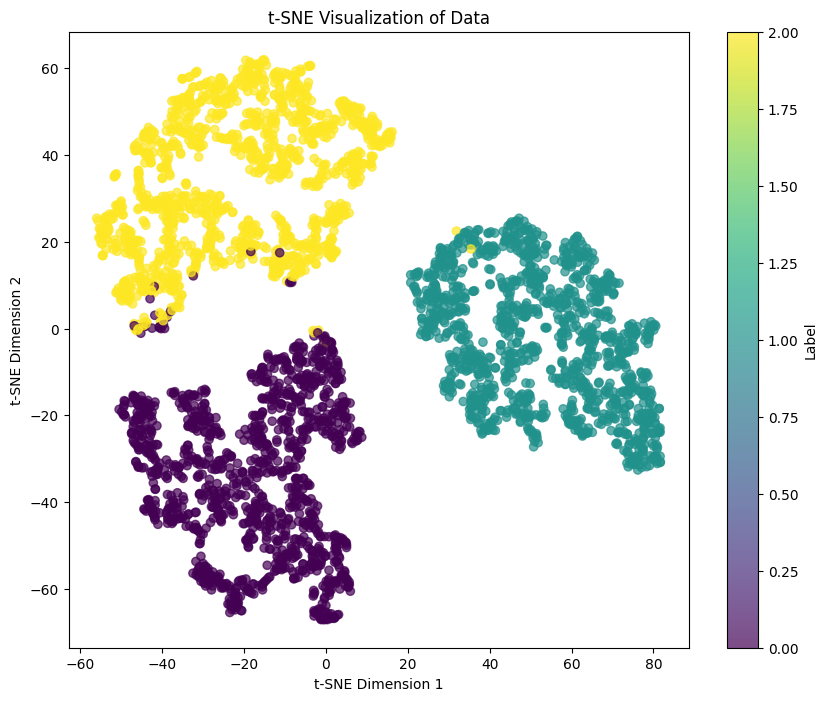

t-SNE Visualization for Cross-Validation Set:
Features shape: (960, 1000)
Labels shape: (960,)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


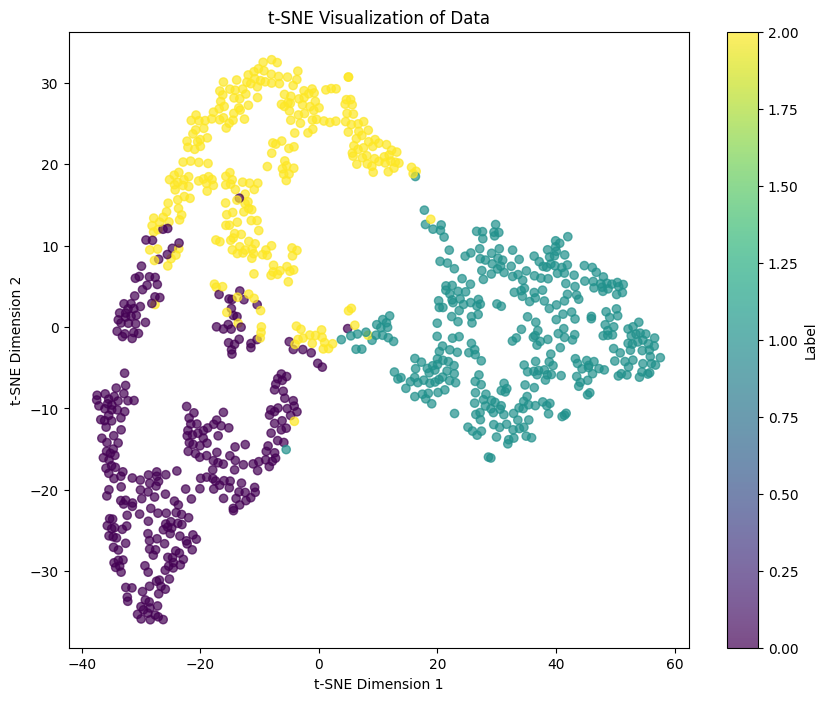

In [ ]:
# Assuming `encoder_model` is the feature extractor model created from your trained model
train_features, train_targets = collect_features_and_targets(train_loader, model)
cross_features, cross_targets = collect_features_and_targets(cross_loader, model)

# Apply t-SNE and visualize
print("t-SNE Visualization for Train Set:")
tsne_visualization(train_features, train_targets)

print("t-SNE Visualization for Cross-Validation Set:")
tsne_visualization(cross_features, cross_targets)
